# 消除自身差异
- 60秒信号取均值，60秒每个样本减去这个均值
- 前30秒作为基线，取均值或直接用后30秒减去前30秒
- 用60秒的高兴信号减去另一个高兴的信号

In [1]:
#加载飞桨、Numpy和相关类库
import numpy as np
import pyeeg as pe
import os
import random
import time

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot

from scipy.stats import wasserstein_distance

In [2]:
#加载一个受试者
def loadSub(sub):
    dir='E:\JupyterNotebookWorkSpace\dataSet\\1280x258050(32x8064+2).npy'
    data=np.load(dir)
    subData = data[sub * 40 : (sub + 1) * 40]
    subData[: , -2:] = np.where(subData[: , -2:] >= 5 , 1 , -1)
    return subData

In [3]:
#数据集切60片
def data_session(subData):
    features = subData[:,:-2]
    labels = subData[:,-2:]
    features = features.reshape(40,32,-1)
    features = features[:,:,384:]
    
    dataList = []
    for i in range(40):
        for j in range(60):
            dataList.append(np.append(features[i][ : , j * 128 : (j + 1) * 128].reshape(-1) , labels[i]))

    dataList = np.array(dataList)

    return dataList

In [4]:
#特征提取
def feature_extraction(trainData):

    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]    
    window_size = 128 #Averaging band power of 1 sec
    step_size = 128 #Each 1 sec update once
    sample_rate = 128 #Sampling rate of 128 Hz

    features = trainData[:,:-2]
    labels = trainData[:,-2:]
    features = features.reshape(features.shape[0],32,128)

    newData=[]
    for i in range(features.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = features[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
            ###################################################################################
        channel_features += list(labels[i])    #添加标签
        newData.append(channel_features)
    trainData = np.array(newData)

    return trainData

In [5]:
# AllSubFreq = []    #保存所有受试者的频域特征32*2400*162
# for sub in range(32):
#     SubData = loadSub(sub)
#     dataList = data_session(SubData)
#     trainData = feature_extraction(dataList)
#     AllSubFreq.append(trainData)
# AllSubFreq = np.array(AllSubFreq)
# print(AllSubFreq.shape)
# AllSubFreq = np.reshape(AllSubFreq, (32, 40, 60, 162))
# print(AllSubFreq.shape)

# # 减去60秒均值
# for sub in range(AllSubFreq.shape[0]):
#     for trail in range(AllSubFreq.shape[1]):
#         mean = AllSubFreq[sub][trail][:, :-2].mean(axis = 0)
#         AllSubFreq[sub][trail][:, :-2] -= mean

# print(AllSubFreq.shape)
# np.save("./AllSubFreq.npy",AllSubFreq)

In [6]:
def Gaussian_normalization(trainData, testData):
    """高斯归一化"""

    #训练样本归一化
    feature=trainData[:,:-2]
    mean=feature.mean(axis=0)
    std=feature.std(axis=0)
    feature-=mean
    feature/=std
    trainData[:,:-2] = feature

    #测试样本归一化
    feature=testData[:,:-2]
    feature-=mean
    feature/=std
    testData[:,:-2] = feature

    return trainData, testData

In [7]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def trainModel(trainData, testData, Edim):
    dim = Edim
    
    trainLabel = trainData[:, -2:]
    trainData = trainData[:, :-2]
    trainLabel = trainLabel[:, dim]
    
    testLabel = testData[:, -2:]
    testData = testData[:, :-2]
    testLabel = testLabel[:, dim]
    
#     svmModel = svm.SVC()
#     svmModel.fit(data_training, valtrain) 
#     ypredict=svmModel.predict(data_testing)
#     print("SVMacc：",accuracy_score(ypredict,valtest)) 

    rfModel = RandomForestClassifier(n_estimators=512, n_jobs=16)
    rfModel.fit(trainData, trainLabel)
    ypredict = rfModel.predict(testData)
    acc = accuracy_score(ypredict,testLabel)
    print("acc = {:.2f}".format(acc))
    return acc

In [8]:
# 数据集划分
AllSubFreq = np.load("./AllSubFreq.npy")
AllSubFreq = AllSubFreq.reshape((-1 , 162))
print(AllSubFreq.shape)

allAcc = []

for SEED in range(100):
    np.random.seed(SEED)
    np.random.shuffle(AllSubFreq)
    ratio = 0.8
    trainSet = AllSubFreq[:int(ratio * AllSubFreq.shape[0])]
    testSet = AllSubFreq[int(ratio * AllSubFreq.shape[0]):]
    if SEED == 0:
        print('trainNum.shape = {}, testNum.shape = {}'.format(trainSet.shape, testSet.shape))

    #------------------------------------是否归一化------------------------------------
    normal = True
    Edim = 0
    if normal:
        trainSet, testSet = Gaussian_normalization(trainSet, testSet)

    # 训练
    acc = trainModel(trainSet, testSet, Edim)
    allAcc.append(acc)

(76800, 162)
trainNum.shape = (61440, 162), testNum.shape = (15360, 162)
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.66
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.65
acc = 0.64
acc = 0.64
acc = 0.64
acc = 0.64
acc = 0.64
acc = 0.64
acc = 0.64
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.65
acc = 0.64
acc = 0.65
acc

In [9]:
allAcc = np.array(allAcc)
index = allAcc.argmax()
print('seed = ',index,'maxAcc = ', allAcc.max())
print('meanAcc = ', allAcc.mean())

seed =  13 maxAcc =  0.65546875
meanAcc =  0.6462929687500001


In [10]:
allAcc.var()

1.3446199205186653e-05

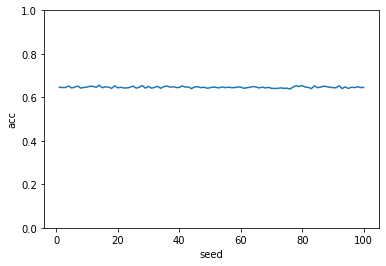

In [11]:
plt.ylim([0,1])
plt.xlabel('seed')
plt.ylabel('acc')
plt.plot(range(1,101), allAcc)